# https://hastie.su.domains/Papers/gap.pdf

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx

from utils import clustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.rcParams.update({'font.size': 18})

In [2]:
def create_graph_comms(N, num_groups, mean_deg, k_out):
    nodes_per_group = N//num_groups; kave = mean_deg; k_out = .2#k_out = .15#kave is local average
    k_in = kave - k_out
    p_in = k_in/nodes_per_group
    p_out = k_out/(nodes_per_group*num_groups - nodes_per_group)
    print('Block model probs: in %f - out %f' % (p_in, p_out))

    G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

    while nx.is_connected(G_gn) == 0:
        print('The network should be in a single component. New trial!')
        G_gn = nx.planted_partition_graph(num_groups, nodes_per_group, p_in, p_out, directed=False)

    infoG_gn = ['GN',k_out]

    print('Mean degree', np.mean(list(dict(G_gn.degree()).values())))
    
    return G_gn

In [122]:
N = 128
num_groups = 4
mean_deg = 16
k_out = .2

G_gn = create_graph_comms(N, num_groups, mean_deg, k_out)
#G_gn = nx.fast_gnp_random_graph(N, p=0.076)
A_gn = nx.to_numpy_array(G_gn)

G_rand = nx.random_reference(G_gn, niter=4)
A_rand = nx.to_numpy_array(G_rand)

G_er = nx.fast_gnp_random_graph(N, p=0.076)
A_er = nx.to_numpy_array(G_er)

Block model probs: in 0.493750 - out 0.002083
Mean degree 15.828125


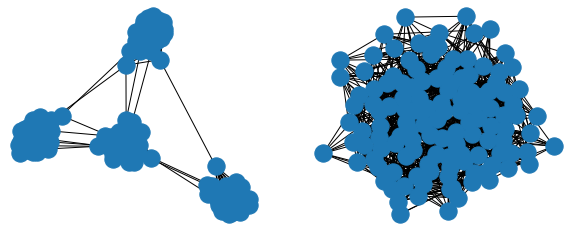

In [4]:
plt.figure(figsize=(10,4))
ax = plt.subplot(1,2,1)
nx.draw(G_gn, ax=ax)
ax = plt.subplot(1,2,2)
nx.draw(G_rand, ax=ax)

In [5]:
avg_dd = clustering.average_distance(-clustering.laplacian(A_gn))

  0%|          | 0/128 [00:00<?, ?it/s]

In [6]:
avg_dd_rand = clustering.average_distance(-clustering.laplacian(A_rand))

  0%|          | 0/128 [00:00<?, ?it/s]

In [92]:
avg_dd_er = clustering.average_distance(-clustering.laplacian(A_er))

  0%|          | 0/128 [00:00<?, ?it/s]

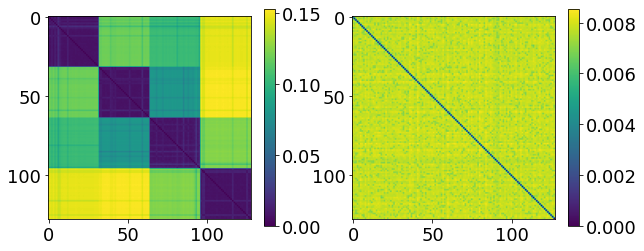

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(avg_dd)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(avg_dd_rand)
plt.colorbar()
plt.show()

In [210]:
def cluster_within_sum(distance, comms):
    distance = distance**2
    n_comms = len(np.unique(comms))
    avg_dd_cluster = np.zeros(n_comms)
    
    for idx in range(n_comms):
        mask = comms==idx
        
        mask = mask[:,None] * mask
        
        avg_dd_cluster[idx] = np.sum(distance[mask]) / 2
        
    return avg_dd_cluster

def compute_best_cluster(avg_dd, n_rand=100, n_clust = np.arange(1,20), show=True):
    Z = linkage(squareform(avg_dd), method='ward')

    dists = np.zeros(len(n_clust))
    dists_rand = np.zeros((len(n_clust),n_rand))

    for i, nn in enumerate(n_clust):
        # Compute clusters
        comms = fcluster(Z, t=nn, criterion='maxclust') -1
        #counts = np.unique(comms, return_counts=True)[1]
        
        # Compute real distance
        dists[i] = np.sum(cluster_within_sum(avg_dd, comms))

        # Compute reference distance
        for idx in range(n_rand):
            # Randomized communities
            np.random.shuffle(comms)
            # Compute randomized distance
            dists_rand[i,idx] = np.sum(cluster_within_sum(avg_dd, comms))
            
    ll = np.mean(np.log(dists_rand), axis=1)
    gap = ll - np.log(dists)
    sd = np.std(np.log(dists_rand), axis=1)
    #sd = sd * np.sqrt(1 +1/n_clust)
    tmp = np.insert(gap, 0, 0)
    delta = tmp[1:]-tmp[:-1]
    delta_sd = np.sqrt(sd**2 + sd**2)
    best = np.argmax(delta)
    best_clust = n_clust[best]
    print(f'best clust={best_clust}')
    
    best_comms = fcluster(Z, t=best_clust, criterion='maxclust') -1

    if show:
        plt.figure(figsize=(8,4))

        ax1 = plt.subplot(1,1,1)

        ax1.plot(n_clust, np.log(dists), 'o-', label='Real', c='k')
        ax1.plot(n_clust, ll, 'o-', label='Randomized', c='blue')

        ax1.set_xlabel('Modules k')
        ax1.set_ylabel(r'$log(W_k)$')
        ax1.legend()
        
        ax2 = ax1.twinx()
        #ax2.errorbar(n_clust, gap, fmt='*-', yerr=sd, capsize=5, ms=4, c='k')
        ax2.plot(n_clust, delta, '*-.', c='green', label=r'$\Delta Gap$')
        ax2.plot(n_clust[best_clust-1], delta[best_clust-1], '*', c='red')
        ax2.set_ylabel(r'$\Delta Gap$')
        ax2.legend()
        
        '''
        ax1 = plt.subplot(1,2,2)

        ax1.errorbar(n_clust, gap, fmt='o-', yerr=sd, capsize=5, ms=4)
        ax1.set_xlabel('Modules k')
        ax1.set_ylabel(r'$Gap_k$')
        
        ax2 = ax1.twinx()
        ax2.plot(gap)
        ax2.set_ylabel(r'$Gap_k$')
        '''
        
        '''
        plt.subplot(1,2,2)
        plt.errorbar(n_clust, delta, yerr=delta_sd, fmt='o-', capsize=5, ms=4)
        plt.plot(n_clust[best], delta[best], 'o', zorder=10, c='red')
        plt.xlabel('Modules k')
        plt.ylabel(r'$Gap_k - Gap_{k-1}$')
        '''
        
        plt.tight_layout()
        plt.show()
        
    return n_clust, np.log(dists), best_clust, best_comms

best clust=4


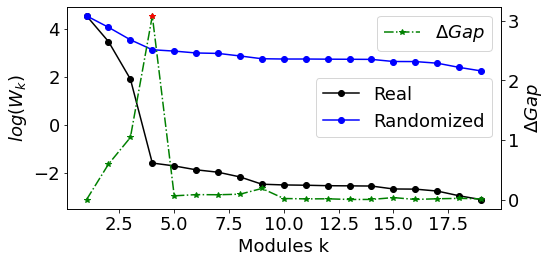

In [211]:
res = compute_best_cluster(avg_dd)

best clust=2


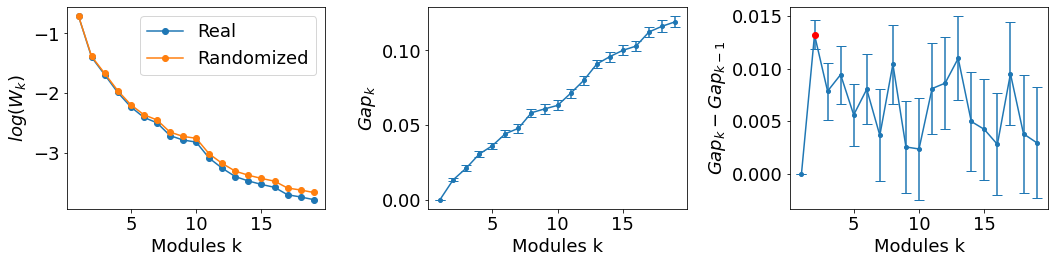

In [142]:
res_rand = compute_best_cluster(avg_dd_rand)

best clust=6


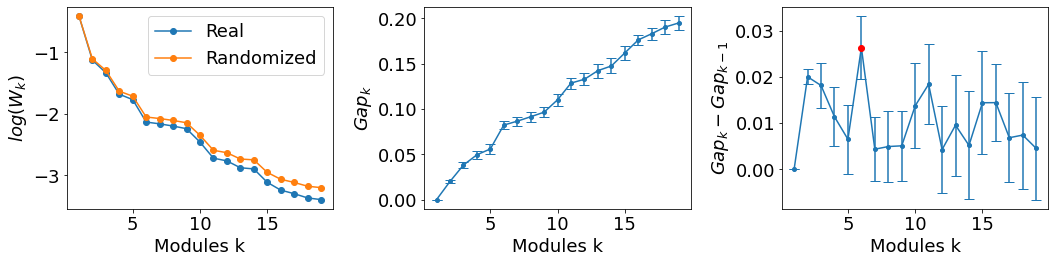

In [143]:
res_rand = compute_best_cluster(avg_dd_er)

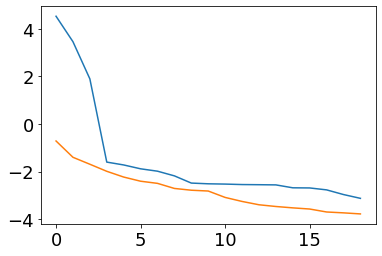

In [83]:
plt.plot(res[1])
plt.plot(res_rand[1])
plt.show()

Block model probs: in 0.246875 - out 0.003125
Mean degree 16.6875


  0%|          | 0/128 [00:00<?, ?it/s]

best clust=2


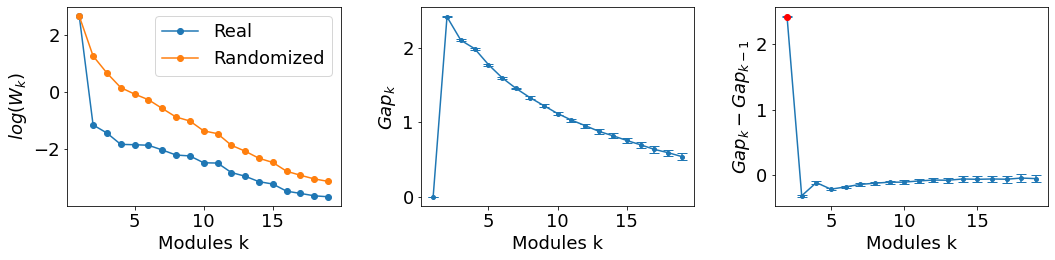

Block model probs: in 0.376190 - out 0.002381
Mean degree 15.761904761904763


  0%|          | 0/126 [00:00<?, ?it/s]

best clust=3


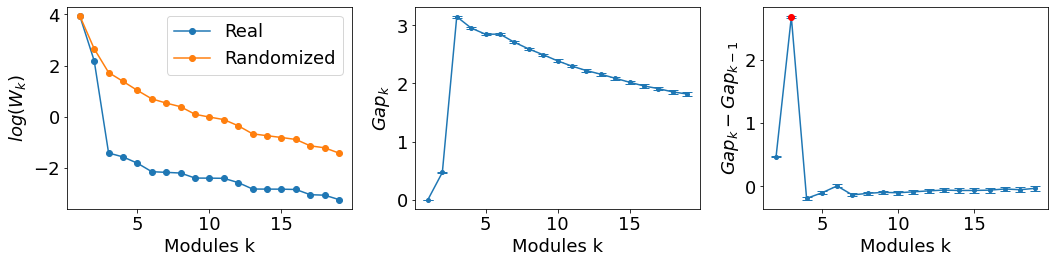

Block model probs: in 0.493750 - out 0.002083
Mean degree 15.890625


  0%|          | 0/128 [00:00<?, ?it/s]

best clust=4


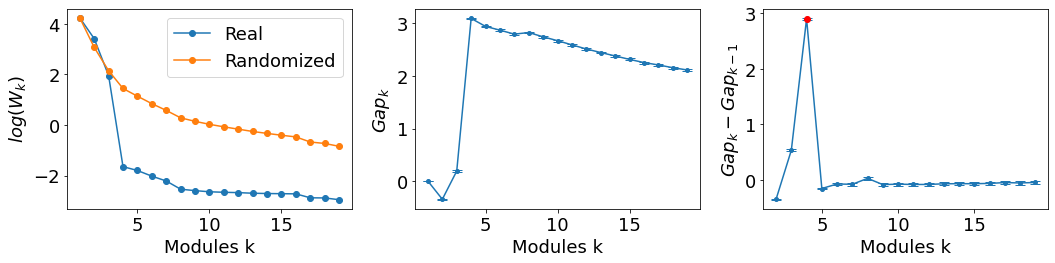

Block model probs: in 0.632000 - out 0.002000
Mean degree 15.568


  0%|          | 0/125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [62]:
groups = [2, 3, 4, 5, 6, 7, 8]

for num_groups in groups:
    mat = create_graph_comms(N, num_groups, mean_deg, k_out)
    
    mat = nx.to_numpy_array(mat)
    
    dd = clustering.average_distance(-clustering.laplacian(mat))
    
    compute_best_cluster(dd)

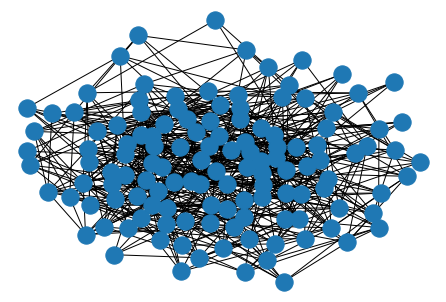

In [118]:
nx.draw(G_er)

In [123]:
comms = clustering.community_detection(A_er, 'louvain')

Found 7 communities


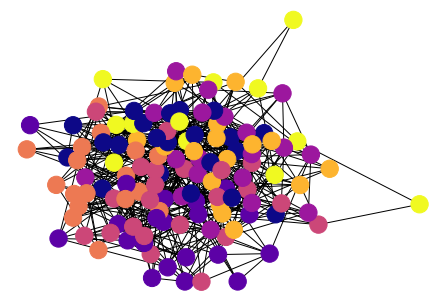

In [124]:
clustering.plot_communities(A_er, comms)

Found 7 communities


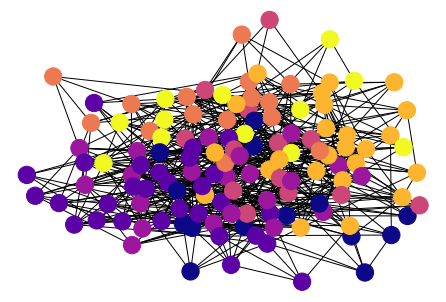

In [156]:
G_er = nx.fast_gnp_random_graph(N, p=0.076)
A_er = nx.to_numpy_array(G_er)

comms = clustering.community_detection(A_er, 'leiden', 1)
clustering.plot_communities(A_er, comms)